In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin1')
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
784,ham,Dont think so. It turns off like randomlly wit...,NaN,NaN,NaN
4867,ham,"Watching cartoon, listening music &amp; at eve...",NaN,NaN,NaN
3847,ham,Can you plz tell me the ans. BSLVYL sent via f...,NaN,NaN,NaN
2704,spam,FreeMsg: Fancy a flirt? Reply DATE now & join ...,NaN,NaN,NaN
1032,ham,HAPPY NEW YEAR MY NO.1 MAN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# Feature 

In [4]:
df=pd.concat([df['v1'],df['v2']],axis=1)

In [5]:
df.columns=['class','sms']

In [6]:
df.head()

,class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.isnull().sum()

class    0
sms      0
dtype: int64

# Label Encoder

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
le=LabelEncoder()
df['class']=le.fit_transform(df['class'])

In [10]:
df['class'].value_counts()

class
0    4825
1     747
Name: count, dtype: int64

# Visual plots

# Word Cloud

In [11]:
df_ham=df[df['class']==0]
df_spam=df[df['class']==1]
df_ham.head(),df_spam.head()

(   class                                                sms
 0      0  Go until jurong point, crazy.. Available only ...
 1      0                      Ok lar... Joking wif u oni...
 3      0  U dun say so early hor... U c already then say...
 4      0  Nah I don't think he goes to usf, he lives aro...
 6      0  Even my brother is not like to speak with me. ...,
     class                                                sms
 2       1  Free entry in 2 a wkly comp to win FA Cup fina...
 5       1  FreeMsg Hey there darling it's been 3 week's n...
 8       1  WINNER!! As a valued network customer you have...
 9       1  Had your mobile 11 months or more? U R entitle...
 11      1  SIX chances to win CASH! From 100 to 20,000 po...)

In [12]:
ham_text=" ".join(df_ham.sms)
spam_text=" ".join(df_spam.sms)

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

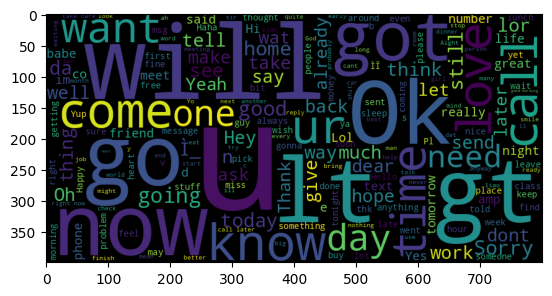

In [14]:
wc=WordCloud(width=800, height=400).generate(ham_text)
plt.imshow(wc)

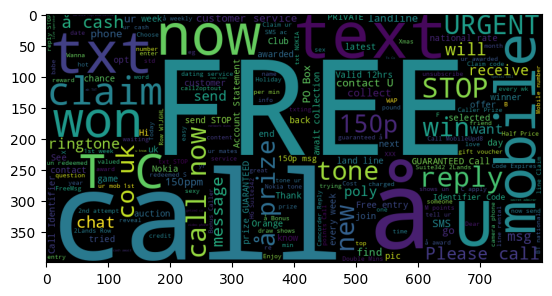

In [15]:
wc=WordCloud(width=800, height=400).generate(spam_text)
plt.imshow(wc)

# Count plot

In [16]:
df['class'].value_counts()

class
0    4825
1     747
Name: count, dtype: int64

<Axes: xlabel='class', ylabel='count'>

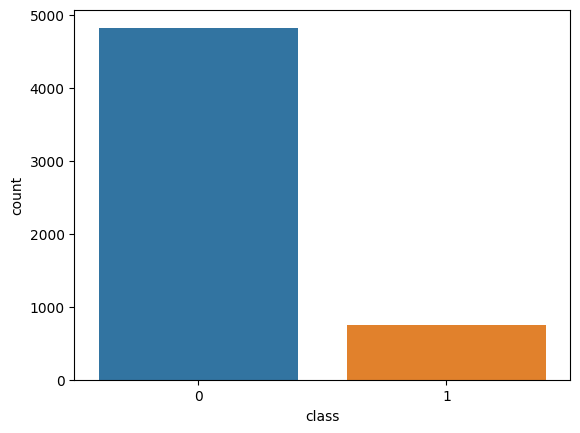

In [17]:
import seaborn as sns
sns.countplot(x=df['class'])

Since the data is imbalance, we will balance the data

# Sampling

Under sampling

In [18]:
df_ham_sampled=df_ham.sample(747)

In [19]:
df_ham_sampled.shape

(747, 2)

# NLP model


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nlp=spacy.load('en_core_web_sm')

In [21]:
model=Pipeline([
    ('vectorizer',TfidfVectorizer(
    tokenizer= lambda sms : (token.lemma_ for token in nlp(sms)),
        stop_words='english',
        ngram_range=(1,2),
        max_features=500
    ))
])

In [22]:
df_prep=model.fit_transform(df['sms'])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'ca', 'far', 'make', 'nt', 'whereaft'] not in stop_words.
  warnings.warn(


# DL model

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_prep,df['class'],test_size=0.2,random_state=1,stratify=df['class'])

In [24]:
X_train.shape,X_test.shape

((4457, 500), (1115, 500))

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,Embedding,Masking

In [26]:
dl_model = Sequential([
    Embedding(input_dim=500,output_dim=128,input_length=500,mask_zero=True),
    Masking(mask_value=0.0),
    LSTM(64,return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [27]:
dl_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
X_train = X_train.toarray()
X_test = X_test.toarray()
epochs = 10
batch_size = 64
history = dl_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
70/70 [==============================] - 48s 588ms/step - loss: 0.4444 - accuracy: 0.8578 - val_loss: 0.3950 - val_accuracy: 0.8664
Epoch 2/10
70/70 [==============================] - 39s 551ms/step - loss: 0.4081 - accuracy: 0.8658 - val_loss: 0.3940 - val_accuracy: 0.8664
Epoch 3/10
70/70 [==============================] - 39s 556ms/step - loss: 0.4093 - accuracy: 0.8658 - val_loss: 0.3939 - val_accuracy: 0.8664
Epoch 4/10
70/70 [==============================] - 39s 559ms/step - loss: 0.4054 - accuracy: 0.8658 - val_loss: 0.3944 - val_accuracy: 0.8664
Epoch 5/10
70/70 [==============================] - 38s 548ms/step - loss: 0.4038 - accuracy: 0.8658 - val_loss: 0.3933 - val_accuracy: 0.8664
Epoch 6/10
70/70 [==============================] - 39s 556ms/step - loss: 0.4078 - accuracy: 0.8658 - val_loss: 0.3945 - val_accuracy: 0.8664
Epoch 7/10
70/70 [==============================] - 39s 555ms/step - loss: 0.4034 - accuracy: 0.8658 - val_loss: 0.3939 - val_accuracy: 0.8664

# Learning curve

In [29]:
def learning_curve(history, epoch):
    # training vs validation accuracy
    epoch_range = range(1,epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()

# training vs validation loss
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()

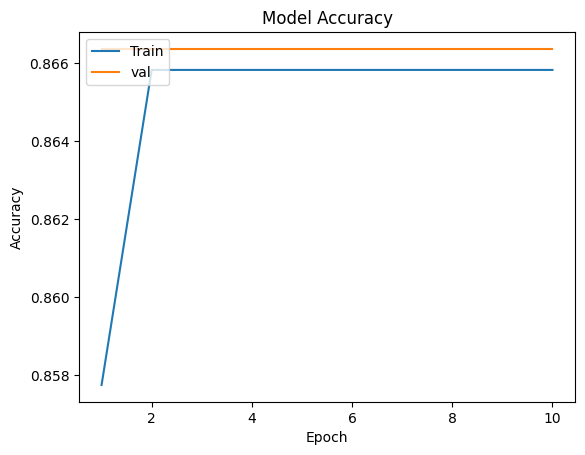

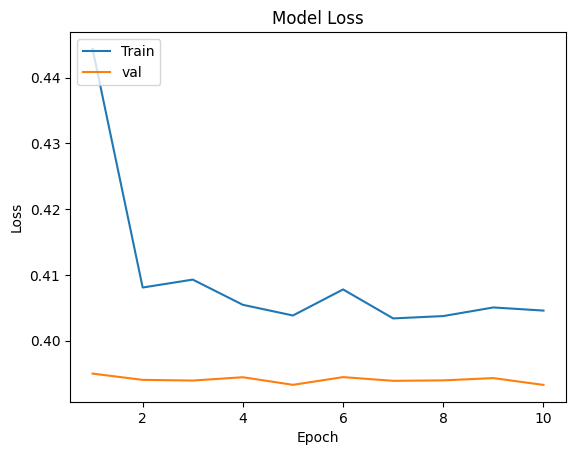

In [30]:
learning_curve(history, 10)